- title: course: (ML Series) Introduction to Machine Learning II
- date: 2020-05-25 12:00
- category: course
- tags: machine learning, python, course
- slug: machine_learn_intro_2
- authors: Julien Hernandez Lallement
- summary: Introduction to Machine Learning II
- illustration: 2020_05_learning_rates2.jpg

## Introduction

This post is the second part of the first [post](https://juls-dotcom.github.io/machine_learn_intro_1.html) on introdution to Machine Learning.

I use several materials to prepare this, such as lectures I attended back in Amsterdam and different books, such as [this one](https://www.amazon.de/Machine-Learning-Applied-Mathematics-Introduction/dp/1916081606) and that [one](https://www.amazon.de/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=bmx_3/260-6773255-8599754?_encoding=UTF8&pd_rd_i=1492032646&pd_rd_r=b1fd8ba5-5d17-4879-816f-a282b1271caa&pd_rd_w=hjnBU&pd_rd_wg=Wg9f2&pf_rd_p=1c6f2f65-ddb5-43f5-b08c-ddcf19e540ae&pf_rd_r=481AWW6FRH1NQGS5T980&psc=1&refRID=481AWW6FRH1NQGS5T980).

Here, I will:
* Introduce scaling 
* Introduce dimensionality & PCA
* Introduce Maximum Likelihood Estimation
* Introduce the concept of bias/variance & Over/Underfitting

### Scaling

If you have already looked a ML pipelines, what you probably noticed is that the first part of pipelines is generall about data processing & transformation, followed by `scaling`. Scaling is a very important step that will allow you to compare the data that will hvae be brought to comparable scales.

Imagine that you are using features such as `number of guitars owned` and `audience attending the concert`, in a dataset of some rock stars. If we would go on and use these data features as they are, the numer of people in the audience would outweight tremendously the number of guitars owned. In turn, that would render the latter feature useless, although it might have brought some explanatory power to your model.

There are different strategies, that will suit differently diverse data projets.

* Maybe the most common, simply use z-scoring method, by taking the mean and standard deviation of the distribution, and rescale all entries to have a mean of 0 and standard deviation of 1
* Take the maximum and minimum and rescale all entries to have a minimum of 0 and a maximum of 1. 

Importantly, the scaling method that you are using should be the same for all the features you are applying it to.

Finally, look out for outliers that might affect the scaling rules. One large value in one feature can cause, after scaling, that feature to be irrelevantly small. Again, common sense will help you understand which scaling makes sense for your project

Sklearn has built in scalers that can be useful, although it is relatively easy to code it on your own.

Below, one example of z score scaling using Sklearn on the ChickWeight dataset:

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklego.preprocessing import ColumnSelector

In [47]:
df

,weight,Time,Chick,Diet
0,42,0,1,1
1,51,4,1,1
2,59,8,1,1
3,64,12,1,1
4,76,16,1,1
...,...,...,...,...
573,175,28,50,4
574,205,32,50,4
575,234,36,50,4
576,264,40,50,4


In [68]:
# Preprocessing pipeline
panda_grabber = Pipeline([
    ("union", FeatureUnion([
        ("continous", Pipeline([
            ("select", ColumnSelector(["weight", "Time"])),
            ("scale", StandardScaler())
        ]))
    ]))
])
# Fit and apply pipeline
scaled_values = panda_grabber.fit(df,df['Diet']).transform(df)

In [69]:
print('Mean after scaling: ', pd.DataFrame(scaled_values, columns=['weight', 'time']).mean().round())
print('Std after scaling: ', pd.DataFrame(scaled_values, columns=['weight', 'time']).std().round())

Mean after scaling:  weight   -0.0
time      0.0
dtype: float64
Std after scaling:  weight    1.0
time      1.0
dtype: float64


Both `weight` and `time` features have been scaled relative to the mean, with a final mean equal to 0 and standard deviation equal to 1.

### Dimensionality

When you are dealing with large data sets, one might be struck by the so-called *curse of dimensionality*. What is that scary thing?!

You might think that the more features you have, the best. There is some truth in there, since you increase the amount of information by adding new data features. That is the purpose of feature engineering. 

However, it has quite some down sides as well.

Say you are working with $N$ data points, each having $M$ features. For demonstration purpose, let's keep things simple, and imagine that your numerical values are binary, i.e., your data is only 0 or 1. There will be therefore $2^M$ combinations. 

If your number of data points $N$ is lower than this combination value, you might have each data points spread over each corner of your $M$-dimensional space. As a direct consequence, the relation between these data points become meaningless because data points become to unique. 

In real world situations, you might be victim of high dimension situations. In such cases, you might want to identify the features that contribute the most to the variance in the data. To do so you would need to prepare your data before running any ML model on it. Below, I discuss a technique that allows you to use less features without explicitly dropping any individual features. 

##### Principal Component Analysis

Principal Component Analysis (PCA) allows you to identify movements in your data set. It is a fancier way to throw away / keep features that provide meaningful explanatory power in the problem you are trying to solve. It can be quite useful for other reasons, such as increasing the speed of algorithm fiting or to visualize data in a new way to identify clusters.

PCA will project the data onto the axes with the highest variance, trying to limit the amount of information lost. As a result, the first principal component (PC) is the axis that preserves the most variance, the second principal component is the one orthogonal to the first that preserves the next most amount of variance...

In more details, a PCA will first find the correlation matrix for all the features you would provide. In a second time, it will find the eigenvectors and eigenvalues of that matrix. 

The eigenvector associated with the largest eigenvalue is the first PC. 
The eigenvector associated with the second largest eigenvalue is the second PC.

The size of the eigenvalue determines how much the component contributes to the variance in the data.

As a result, instead of throwing away features that you feel would have high importance, you can use PCA to throw away features with low eigenvalues. Even better, you keep the features that provide a certain threshold of explainability (say 95%).

Let's produce an example. This was inspired by the [repository](https://github.com/tfolkman) Tyler Folkman.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

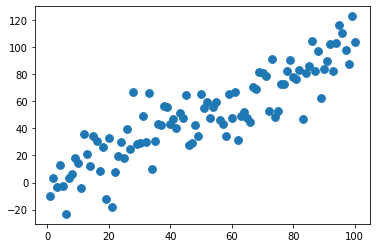

In [4]:
df= pd.DataFrame({'X': range(1,101), 
                  'Y': np.random.randn(100)*15+range(1,101)})
plt.scatter(df['X'], df['Y'], s=60)

We then subtract the mean from each column (PCA assumes that the data are centered around it).

In [12]:
df_scaled = df - df.mean()
# Perform a Singular Value Decomposition to obtain each of the PC
U, s, V = np.linalg.svd(df_scaled.values)
# Extract each PC
PC1 = V.T[:, 0]
PC2 = V.T[:, 1]
print(PC1)
print(PC2)

[0.66394075 0.74778518]
[ 0.74778518 -0.66394075]


Now that we have these principal components, we just need to project the data onto them. You do this with a simple dot product:

In [13]:
# Compute the matrix product between the scaled data and the first PC
data_projected_PC1 = df_scaled.dot(PC1)

W can visualize the projected our data onto the first principal component:

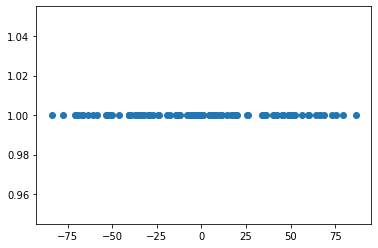

In [17]:
plt.scatter(data_projected_PC1, np.ones(len(data_projected_PC1)))

And here is for projecting just on PC2:

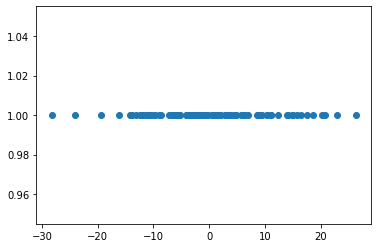

In [19]:
data_projected_PC2 = df_scaled.dot(PC2)
plt.scatter(data_projected_PC2, np.ones(len(data_projected_PC2)))

We can see how the first plot show higher variance [-80 +80] than the second [-30 +30]. Remember what I said earlier about components explaning as much variance as possible, which explains why the PC1 has the highest variance

We can reproduce our data by projecting onto the first two components, and then inverting the process. Note that it exactly reproduces our data because we originally had 2 features and used both principal components.

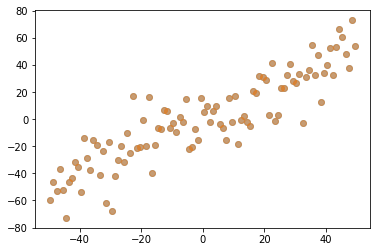

In [20]:
data_projected_PC12 = df_scaled.dot(V.T)
reconstruct = data_projected_PC12.dot(V)
plt.scatter(reconstruct.values[:,0], reconstruct.values[:,1], alpha=0.5)
plt.scatter(df_scaled['X'], df_scaled['Y'], alpha=0.5)

Finally, we can also check that our principle components are indeed orthogonal. 

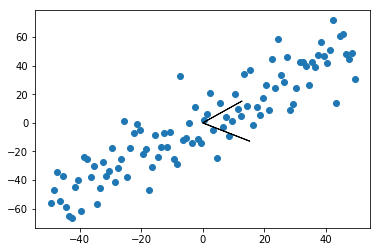

In [8]:
plt.scatter(df_scaled.values[:,0], df_scaled.values[:,1])
plt.arrow(x=0,y=0,dx=c1[0]*20,dy=c1[1]*20)
plt.arrow(x=0,y=0,dx=c2[0]*20,dy=c2[1]*20)

Let's look at how we can implement it quite easily in Python and Sklearn

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris_dataset = load_iris()
X, y = iris_dataset['data'], iris_dataset['target']
# Scale data
X = StandardScaler().fit_transform(X)

After standardizing the data, we can apply the PCA.

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
PrinComp = pca.fit_transform(X)
df_clean = pd.DataFrame(data = PrinComp, columns = ['Component #1', 'Component #2'])
df_clean = df_clean.assign(target = pd.Series(y))

Let's plot the results to see what we got:

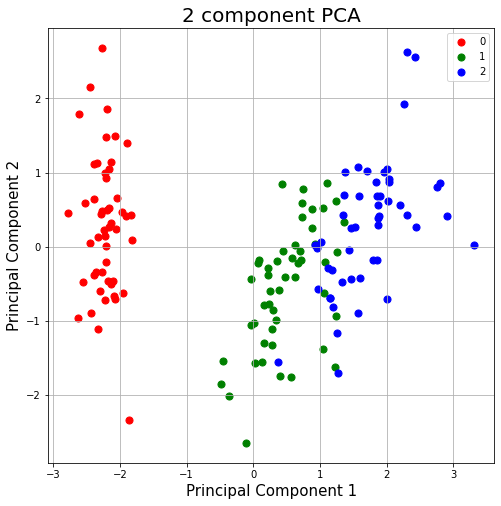

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_clean['target'] == target
    ax.scatter(df_clean.loc[indicesToKeep, 'Component #1']
               , df_clean.loc[indicesToKeep, 'Component #2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

One important thing to check after running the PCA is how much of the variance is explained by the different components. You want to have enough variance explained, otherwise you are loosing too much information by boiling down the data to principal components

In [69]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762])

We can see that the two component contains 73% and 23% of the variance, which brings you close enough to most of the variance in the data.

Let's graph this ratio cumulatively for all of our components:

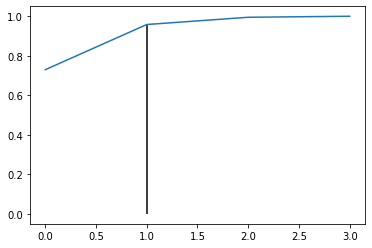

In [33]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[1],x=1)

We can see from above how our explained ratio increases to 100 percent as we continue to add principal components. We also see an elbow in our graph at 2 components. Thus, one option would be to use 2 components when reducing the dimensionality since the rate of reduction in variance decreases after that. Another option would be to use the number of components necessary to reach a certain amount of explained variance. For example, we could calculate how many components we would need to explain at least 99% of the variance

In [35]:
index_95 = np.argmax(cum_ratio >= 0.99)
print(index_95)
print(cum_ratio[index_95])

2
0.9948212908928452


Thus - we would need 2 components to explain 99.48% of the variance in our data. Sklearn can also take this 0.99 fraction as n_components and will automatically use the number of components necessary to reach that amount of explained variance:

In [36]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(150, 2)


##### t-SNE

t-SNE is a dimensionality reduction technique as well, but to my understanding it is mostly used for visualization and not data pre-processing. For this reason, you almost always reduce the dimensionality down to 2 with t-SNE, so that you can then plot the data in two dimensions.

The reason this is is because t-SNE's goal is to take your high dimensional data and represent it correctly in lower dimensions - thus points that are close in high dimensions should remain close in low dimensions. It does this in a non-linear and local way, so different regions of data could be transformed differently. 
 
I won't be going in details about this method here since I have not used it extensively. Check out this [article on t-SNE](https://distill.pub/2016/misread-tsne/).

### Maximum Likelihood Estimation

Maximum Likelihood Estimation (MLE) is a classic approach to determine parameters in a mathematical model. It works by finding the parameters that maximizes the likelihood of observing the real data. 

Say you go the cinema and you get a ticket stamped with the number "152" on it. What is the probability of getting that ticket?
We need to assume that the ticket numbers are positive, and that the numbering is independent per movie. 

If N is the number of people that are going to the movie, then the probability of getting that ticket is:

$
\frac{1}{N}$ for N > or equal to 152


and the value that maximizes that expression (in other words, the MLE) would be 152 of course.

##### What am I telling you this?

Finding the parameters that best approach the likelihood of the data under the hypothesis is what will bring your model closer to the truth.

The example above is a simple one, but one could look at another, still not complicated one: coss toin.

Say you toss a coin $n$ times and get $i$ heads. What is the probability of cossing heads again at the next toss?

Well, if the tosses are independent, then the probability would be:

$
\frac{n!}{h!(n-h)!} p^h (1-p)^n-h
$

The likelihood function will have a clear maximum, which will be affected by $i$, and applying MLE to this problem boils down to maximizing this expression with respect to $p$. 

Note that when working with probabilities, you will often work with the logarithmic of the likelihood, instead of the raw value. And that will be the terms you will try to maximize (AKA `log likelihood`). The main reason (as far as I know, fact check this!) is that it will allow you to move away from very small number, which will give you less precision eventually.

### Bias and Variance

When you find a relation between an independent $x$ and dependent variable $y$, you can write it in mathematical terms. For example 

$
y = f(x) + \epsilon
$

The term $\epsilon$ refers to the error, which represents some random noise in the data, or systematic noise due to measurement error (often the case in research projects...I should know).

We now come up with an ML model that will be fitted on training data, and minimizing some cost function (think MSE, as in linear regressions). 

What you will often observe is that increasing the number of parameters in your model would reduce the error, sometimes drastically, **on the training data set**. 

Now, of course, you want to predict unseen, new and fresh data points. That data point will also have an error term when piped through the model. But in addition to its own error term, it will receive the error based on the conten of the training set, that is, what the model has seen so far. 

I must say, the math behind this part is still not familiar to me, so I will skip the equations for now. What is important, is that the difference between the expectation and the real data point is modulated by both `Bias` and `Variance` (as well as the error inherent to the data, discussed before as term $\epsilon$).

`Bias` is the divergence is our model compared to our real data, on average. 
`Variance` is a measure of the magnitude of that error

We are stuck with $\epsilon$ (except if we have ways to identify systematic error patterns due to measurements error for example), but we can play around to affect Variance and Bias. A good model would have low bias and low variance. Unfortunately, we often have to find a good balance between these two terms, which refers to the terms of `Overfitting` and `Underfitting`.

#### Underfitting vs. Overfitting

Once you have managed to find the optimum for the cost function, you might have at hand a model that is quite good at predicting data. However, as mentioned before, the residuals typically are calculated on training sets, that is, data that you give the model for it learn the association between the variables. One trap here is to create models that are extremes, that is, they will not generalize well to unseen data because of the way they were trained or programed. <br><br>

This is a very important concept, that will define whether your models will be useful or not 

I insist again: the learned model is only useful if it is able to generalize from the data and allows for prediction.
In other words, a good model shoud
- **only** estimate the **systematic relationships** $f$ in the data
- **ignore** the **random noise** in the data, hence, unsystematic error 

Look at the figure below.<br>

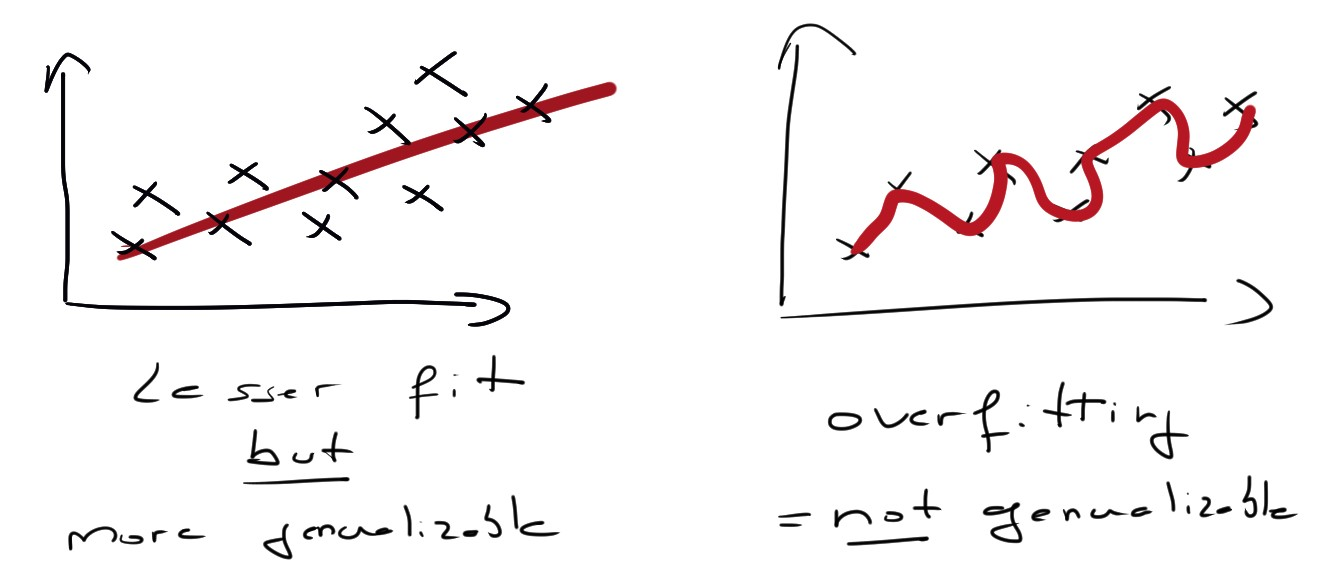

In [3]:
from IPython.display import Image
PATH = "/home/julien/website/content/images/2020_05_ML_Intro_I/"
Image(filename = PATH + "fitting_regimes_crop.jpg", width=800, height=500)

It might be unintuitive for novices in the field, but the model on the right is not a good model to use, because it is too fitted (overfitted) to the train data, and won't be able to capture systematic association between the variables, because too busy capturing the small irrelevant fluctuations present in your current training dataset. The model on the left however might be less accurate on that particular dataset, but will most likely be better at predicting unseen data 

What every engineer and scientist wants is an accurate model that generalizes well on unseen data. The model's performance can be quantified as a value that will be located on a continuum between two extreme cases:
* Underfitting: the model cannot learn the problem. 
* Overfitting:  the model doesn't generalize.

Underfitting means that the model cannot learn the assiciation between variables and target data, maybe because it is missing some features, maybe simply because the model is too simple.

Overfitting means that the model doesn't generalize well, maybe because the model learns to recognize patterns in the data without detecting the intrisic patterns in it, which in turn makes it completely able to detect noise specific to your dataset and unable to detect trends specific to the overall data population from which your sample is taken.

### Final words

That's it for now. In following posts, I will be reporting how I showed and explained futher steps of machine learning project such as model fitting, evaluation and selection. Keep posted!